In [186]:
#%reset
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn import metrics

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, matthews_corrcoef
from num2words import num2words
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, KFold, RepeatedStratifiedKFold
from sklearn.metrics import f1_score, matthews_corrcoef, roc_auc_score
import word2number
from word2number import w2n
from sklearn.tree import DecisionTreeClassifier
import pickle
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay
import random
from matplotlib.patches import Polygon

from Functions import prep_training_test_data, prep_training_test_data, calculate_metrics,cross_validation_leave_geo_out, prep_training_test_data, add_labels_to_subplots, LOOCV_by_HSA_dataset, save_in_HSA_dictionary, prepare_data_and_model, calculate_maximum_reget
hfont = {'fontname':'Helvetica'}
palette = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854', '#e5c494']


# Load data

In [188]:
HSA_weekly_data_all = pd.read_csv("/Users/rem76/Documents/COVID_projections/hsa_time_data_all_dates_weekly_incl_NA.csv")
columns_to_remove = [col for col in HSA_weekly_data_all.columns if 'cases' in col]
HSA_weekly_data_no_cases_no_deaths = HSA_weekly_data_all.drop(columns=columns_to_remove)

columns_to_remove = [col for col in HSA_weekly_data_no_cases_no_deaths.columns if 'deaths' in col]
HSA_weekly_data_no_cases_no_deaths = HSA_weekly_data_no_cases_no_deaths.drop(columns=columns_to_remove)

In [189]:
columns_to_select = HSA_weekly_data_all.filter(regex="HSA|beds_over_15_100k|weight|perc_covid|beds_delta|beds|icu").columns.tolist()
HSA_weekly_data_all = HSA_weekly_data_all[columns_to_select]


Create naive dataset

In [190]:
columns_to_select = HSA_weekly_data_all.filter(regex="HSA|beds_over_15_100k|weight").columns.tolist()
naive_data = HSA_weekly_data_all[columns_to_select]

# Polygons for mapping onto graphs

In [191]:
## County Data 


data_by_county = pd.read_csv('/Users/rem76/Documents/COVID_projections/county_time_data_all_dates.csv')

data_by_county = data_by_county.dropna(subset=['admits_weekly', 'deaths_weekly', 'cases_weekly', 'icu_weekly', 'beds_weekly', 'perc_covid'])
data_by_county['CTYNAME'] = data_by_county['CTYNAME'].apply(lambda x: x.split()[0])
data_by_county['CTYNAME'] = data_by_county['fips'].astype(str) + '' + data_by_county['CTYNAME']
data_by_county['beds_over_15_100k'] = (data_by_county['beds_weekly'] > 15) * 1

# Redo dates
for i, week in enumerate(data_by_county['date'].unique()):
    data_by_county.loc[data_by_county['date'] == week, 'week'] = i

## DELTA POLYGON 

start_date = pd.to_datetime('2021-06-30')
end_date = pd.to_datetime('2021-10-26')
data_by_county['date'] = pd.to_datetime(data_by_county['date'])
for i, week in enumerate(data_by_county['date'].unique()):
    data_by_county.loc[data_by_county['date'] == week, 'week'] = i
# Find the indices of rows that match the exact start and end dates
matching_indices_start = data_by_county.loc[data_by_county['date'] <= start_date].index.max()
matching_indices_end = data_by_county.loc[data_by_county['date'] <= end_date].index.max()
first_week_delta = data_by_county.loc[matching_indices_start, 'week']
last_week_delta = data_by_county.loc[matching_indices_end, 'week']
start_date = pd.to_datetime('2021-10-26')
end_date = pd.to_datetime('2022-09-27')
data_by_county['date'] = pd.to_datetime(data_by_county['date'])
for i, week in enumerate(data_by_county['date'].unique()):
    data_by_county.loc[data_by_county['date'] == week, 'week'] = i
# Find the indices of rows that match the exact start and end dates
matching_indices_start = data_by_county.loc[data_by_county['date'] <= start_date].index.max()
matching_indices_end = data_by_county.loc[data_by_county['date'] <= end_date].index.max()
first_week_omricon = data_by_county.loc[matching_indices_start, 'week']
last_week_omricon = data_by_county.loc[matching_indices_end, 'week']

## CDC POLYGON 
start_date = pd.to_datetime('2021-03-01')
end_date = pd.to_datetime('2022-01-24')
data_by_county['date'] = pd.to_datetime(data_by_county['date'])
for i, week in enumerate(data_by_county['date'].unique()):
    data_by_county.loc[data_by_county['date'] == week, 'week'] = i
# Find the indices of rows that match the exact start and end dates
matching_indices_start = data_by_county.loc[data_by_county['date'] <= start_date].index.max()
matching_indices_end = data_by_county.loc[data_by_county['date'] <= end_date].index.max()
first_week_CDC = data_by_county.loc[matching_indices_start, 'week']
last_week_CDC = data_by_county.loc[matching_indices_end, 'week']

/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_2500/4200828156.py:4: DtypeWarning: Columns (47,48,49,50,51,55,56) have mixed types. Specify dtype option on import or set low_memory=False.
  data_by_county = pd.read_csv('/Users/rem76/Documents/COVID_projections/county_time_data_all_dates.csv')


# Percent exceeding capacity 

In [192]:
percent_exceed_capacity = []

# Iterate through the columns of the DataFrame
for column_name in HSA_weekly_data_all.columns:
    if 'beds_over_15_100k' in column_name:
        # Calculate the sum of the column and append it to the list
        column_sum = HSA_weekly_data_all[column_name].sum()/len(HSA_weekly_data_all[column_name])
        percent_exceed_capacity.append(column_sum)

# Global values

In [193]:
no_iterations = 10
geography_column = 'HSA_ID'  
geo_split = 0.9  
time_exact = 'exact'  # Choose 'period', 'exact', or 'exact'
size_of_test_dataset = 4
train_weeks_for_initial_model = 4

weeks_in_future = 3 
weight_col = 'weight'  
keep_output = True  

no_iterations_param = 8
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(2, 5, 1)} 

# Create the Decision Tree classifier
cv = RepeatedStratifiedKFold(n_splits=10,  n_repeats=10,random_state=1) ## 10-fold cross validations

# Naive classifier

In [194]:
weeks_to_predict = range(1, 113, 4)

In [195]:


ROC_by_week_naive_4 = []
accuracy_by_week_naive_4 = []
norm_MCC_by_week_naive_4 = []

for prediction_week in weeks_to_predict:
    print(prediction_week)
    print(range(1 , int(prediction_week + train_weeks_for_initial_model) + 1))
    print(range(int(prediction_week + train_weeks_for_initial_model) + 1, int(prediction_week + train_weeks_for_initial_model + size_of_test_dataset) + 1))
    #period    

  
        # exact
    X_train_naive_exact, y_train_naive_exact, weights_naive_exact, missing_data_train_HSA = prep_training_test_data(naive_data, no_weeks=range(1 , int(prediction_week + train_weeks_for_initial_model) + 1), weeks_in_future=3, geography=geography_column, weight_col='weight', keep_output=True)

    X_test_naive_exact, y_test_naive_exact, weights_test_naive_exact, missing_data_test_HSA = prep_training_test_data(naive_data, no_weeks=range(int(prediction_week + train_weeks_for_initial_model) + 1, int(prediction_week + train_weeks_for_initial_model + size_of_test_dataset) + 1), weeks_in_future=3, geography=geography_column, weight_col='weight', keep_output=True)
    weights_naive_exact = weights_naive_exact[0].to_numpy()
    # no hyperparameter tuning as it's the same irrespective of hyperparameters
    clf_naive = DecisionTreeClassifier(random_state=10, class_weight='balanced')
    clf_naive.fit(X_train_naive_exact, y_train_naive_exact, sample_weight=weights_naive_exact)

    # Make predictions on the test set
    y_pred = clf_naive.predict(X_test_naive_exact)
    y_pred_proba = clf_naive.predict_proba(X_test_naive_exact)

    # Evaluate the accuracy of the model
    accuracy_by_week_naive_4.append(accuracy_score(y_test_naive_exact, y_pred))
    ROC_by_week_naive_4.append(roc_auc_score(y_test_naive_exact, y_pred_proba[:, 1]))
    conf_matrix = confusion_matrix(y_test_naive_exact, y_pred)
    norm_MCC_by_week_naive_4.append((matthews_corrcoef(y_test_naive_exact, y_pred) + 1)/2)

1
range(1, 6)
range(6, 10)
5
range(1, 10)
range(10, 14)
9
range(1, 14)
range(14, 18)
13
range(1, 18)
range(18, 22)
17
range(1, 22)
range(22, 26)
21
range(1, 26)
range(26, 30)
25
range(1, 30)
range(30, 34)
29
range(1, 34)
range(34, 38)
33
range(1, 38)
range(38, 42)
37
range(1, 42)
range(42, 46)
41
range(1, 46)
range(46, 50)
45
range(1, 50)
range(50, 54)
49
range(1, 54)
range(54, 58)
53
range(1, 58)
range(58, 62)
57
range(1, 62)
range(62, 66)
61
range(1, 66)
range(66, 70)
65
range(1, 70)
range(70, 74)
69
range(1, 74)
range(74, 78)
73
range(1, 78)
range(78, 82)
77
range(1, 82)
range(82, 86)
81
range(1, 86)
range(86, 90)
85
range(1, 90)
range(90, 94)
89
range(1, 94)
range(94, 98)
93
range(1, 98)
range(98, 102)
97
range(1, 102)
range(102, 106)
101
range(1, 106)
range(106, 110)
105
range(1, 110)
range(110, 114)
109
range(1, 114)
range(114, 118)


# Metrics from loaded models

In [198]:

# Initialize lists to store results


ROC_by_week_full_4 = []
accuracy_by_week_full_4 = []
norm_MCC_by_week_full_4= []

size_of_test_dataset = 4
keep_output = True
for prediction_week in weeks_to_predict:
    # Evaluate the period model
    model_name = "/Users/rem76/Documents/COVID_projections/Exact_analysis_smaller_hyperparameters/Expanding_models_four_week_delivery/Full_model_smaller_hyperparameters"
    accuracy_exact, roc_auc_exact, mcc_exact = prepare_data_and_model(HSA_weekly_data_all, weeks_in_future, geography_column, weight_col, keep_output,'exact', model_name, prediction_week, size_of_test_dataset, train_weeks_for_initial_model)
    accuracy_by_week_full_4.append(accuracy_exact)
    ROC_by_week_full_4.append(roc_auc_exact)
    norm_MCC_by_week_full_4.append(mcc_exact)



# CDC A

In [200]:

# Initialize lists to store results

ROC_by_week_CDC_A_4 = []
accuracy_by_week_CDC_A_4 = []
norm_MCC_by_week_CDC_A_4 = []

size_of_test_dataset = 4
keep_output = False
for prediction_week in weeks_to_predict:
    # Evaluate the period model
    model_name = "/Users/rem76/Documents/COVID_projections/Exact_analysis_smaller_hyperparameters/Expanding_models_four_week_delivery/CDC_A_smaller_hyperparameters"
    accuracy_exact, roc_auc_exact, mcc_exact = prepare_data_and_model(HSA_weekly_data_all, weeks_in_future, geography_column, weight_col, keep_output,'exact', model_name, prediction_week, size_of_test_dataset, train_weeks_for_initial_model)
    accuracy_by_week_CDC_A_4.append(accuracy_exact)
    ROC_by_week_CDC_A_4.append(roc_auc_exact)
    norm_MCC_by_week_CDC_A_4.append(mcc_exact)

# CDC B

In [201]:
# Initialize lists to store results

ROC_by_week_CDC_B_4 = []
accuracy_by_week_CDC_B_4 = []
norm_MCC_by_week_CDC_B_4 = []

size_of_test_dataset = 4
keep_output = True
for prediction_week in weeks_to_predict:
    # Evaluate the period model
    print(prediction_week)
    model_name = "/Users/rem76/Documents/COVID_projections/Exact_analysis_smaller_hyperparameters/Expanding_models_four_week_delivery/CDC_B_smaller_hyperparameters"
    accuracy_exact, roc_auc_exact, mcc_exact = prepare_data_and_model(HSA_weekly_data_all, weeks_in_future, geography_column, weight_col, keep_output,'exact', model_name, prediction_week, size_of_test_dataset, train_weeks_for_initial_model)
    accuracy_by_week_CDC_B_4.append(accuracy_exact)
    ROC_by_week_CDC_B_4.append(roc_auc_exact)
    norm_MCC_by_week_CDC_B_4.append(mcc_exact)

1
5
9
13
17
21
25
29
33
37
41
45
49
53
57
61
65
69
73
77
81
85
89
93
97
101
105
109


# No cases no deaths

In [202]:
# Initialize lists to store results

ROC_by_week_no_c_d_4 = []
accuracy_by_week_no_c_d_4 = []
norm_MCC_by_week_no_c_d_4 = []

size_of_test_dataset = 4
keep_output = True
for prediction_week in weeks_to_predict:
    # Evaluate the period model
    model_name = "/Users/rem76/Documents/COVID_projections/Exact_analysis_smaller_hyperparameters/No_cases_no_deaths/4_week_delivery/No_cases_no_deaths_smaller_hyperparameters"
    accuracy_exact, roc_auc_exact, mcc_exact = prepare_data_and_model(HSA_weekly_data_all, weeks_in_future, geography_column, weight_col, keep_output,'exact', model_name, prediction_week, size_of_test_dataset, train_weeks_for_initial_model)
    accuracy_by_week_no_c_d_4.append(accuracy_exact)
    ROC_by_week_no_c_d_4.append(roc_auc_exact)
    norm_MCC_by_week_no_c_d_4.append(mcc_exact)

# Maximum regret 


In [213]:
with open('/Users/rem76/Documents/COVID_projections/ROC_by_week_full_exact.pkl', 'rb') as f:
    ROC_by_week_full_exact = pickle.load(f)
with open('/Users/rem76/Documents/COVID_projections/ROC_by_week_naive_exact.pkl', 'rb') as f:
    ROC_by_week_naive_exact= pickle.load(f)

with open('/Users/rem76/Documents/COVID_projections/ROC_by_week_CDC_A_exact.pkl', 'rb') as f:
    ROC_by_week_CDC_A_exact = pickle.load(f)
with open('/Users/rem76/Documents/COVID_projections/ROC_by_week_CDC_B_exact.pkl', 'rb') as f:
    ROC_by_week_CDC_B_exact= pickle.load(f)

with open('/Users/rem76/Documents/COVID_projections/ROC_by_week_no_c_d_exact.pkl', 'rb') as f:
    ROC_by_week_full_exact_removed = pickle.load(f)

with open('/Users/rem76/Documents/COVID_projections/percent_exceed_capacity.pkl', 'rb') as f:
    exceed_threshold= pickle.load(f)

with open('/Users/rem76/Documents/COVID_projections/ROC_by_week_CL_mod.pkl', 'rb') as f:
    ROC_by_week_CL_mod = pickle.load(f)

In [238]:
ROC_by_week_CL_exact_MR

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.675946726572529,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [260]:
indices = np.array(list(range(1, 113, 4)))
ROC_by_week_naive_exact_MR = [ROC_by_week_naive_exact[i] for i in indices]
ROC_by_week_CDC_A_exact_MR = [ROC_by_week_CDC_A_exact[i] for i in indices]
ROC_by_week_CDC_B_exact_MR = [ROC_by_week_CDC_B_exact[i] for i in indices]
ROC_by_week_full_exact_MR = [ROC_by_week_full_exact[i] for i in indices]
ROC_by_week_no_c_d_exact_MR = [ROC_by_week_full_exact_removed[i] for i in indices]
ROC_by_week_CL_exact_MR = [ROC_by_week_CL_mod[i] for i in indices]


model_metric_ROC_expand_MR = {
    'roc_values_naive_expand': ROC_by_week_naive_exact_MR,
    'roc_values_CDC_A_expand':ROC_by_week_CDC_A_exact_MR,
    #'roc_values_CDC_B_expand': ROC_by_week_CDC_B_exact_MR, 
    'roc_values_no_c_d_expand': ROC_by_week_no_c_d_exact_MR, 
    'roc_values_full_expand': ROC_by_week_full_exact_MR, 
    'roc_values_CL_expand': ROC_by_week_CL_exact_MR
}

model_metric_ROC_expand = {
    'roc_values_naive_expand': ROC_by_week_naive_exact,
    'roc_values_CDC_A_expand':ROC_by_week_CDC_A_exact,
    #'roc_values_CDC_B_expand': ROC_by_week_CDC_B_exact, 
    'roc_values_no_c_d_expand':ROC_by_week_full_exact_removed,
    'roc_values_full_expand': ROC_by_week_full_exact, 
    'roc_values_CL_expand': ROC_by_week_CL_mod
}
model_metric_ROC_4 = {
    'roc_values_naive_4': ROC_by_week_naive_4,
    'roc_values_CDC_A_4': ROC_by_week_CDC_A_4,
    #'roc_values_CDC_B_4': ROC_by_week_CDC_B_4,
    'roc_values_no_c_d_4': ROC_by_week_no_c_d_4,
    'roc_values_full_4': ROC_by_week_full_4, 
    'roc_values_CL_expand': ROC_by_week_CL_exact_MR
}


weeks_to_predict = range(0, 28)
weeks_to_predict_full = range(0, 117)

all_metrics_expand_MR = {}
all_metrics_expand = {}
all_metrics_4 = {}
all_metrics_expand['ROC'] = model_metric_ROC_expand
all_metrics_expand_MR['ROC'] = model_metric_ROC_expand_MR
all_metrics_4['ROC'] = model_metric_ROC_4


models_expand = ['Naive: expand', 'CDC A: expand', 'No cases or deaths: expand',  'Full: expand', 'CDC CL' ]
models_4 = ['Naive: 4',  'CDC A: 4', 'No cases or deaths: 4', 'Full: 4', 'CDC CL']
maximum_regret_by_model_ROC_expand =calculate_maximum_reget('ROC', all_metrics_expand, models_expand, time_period, weeks_to_predict_full)

maximum_regret_by_model_ROC_expand_abbreviated =calculate_maximum_reget('ROC', all_metrics_expand_MR, models_expand, time_period, weeks_to_predict)
maximum_regret_by_model_ROC_4 =calculate_maximum_reget('ROC', all_metrics_4, models_4, time_period, weeks_to_predict)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27


In [261]:
indices_for_CL_MR_4 = []
for i, score in enumerate(maximum_regret_by_model_ROC_4['CDC CL']):
    if score < 0.5: #to get the ones where the ROC wasn't set to 0
       indices_for_CL_MR_4.append(i)


indices_for_CL_MR = []
for i, score in enumerate(maximum_regret_by_model_ROC_expand['CDC CL']):
    if score < 0.5:
       indices_for_CL_MR.append(i)

In [262]:
indices_for_CL = []
for i, score in enumerate(ROC_by_week_CL_mod):
    if score > 0:
       indices_for_CL.append(i)

0
1
2
3


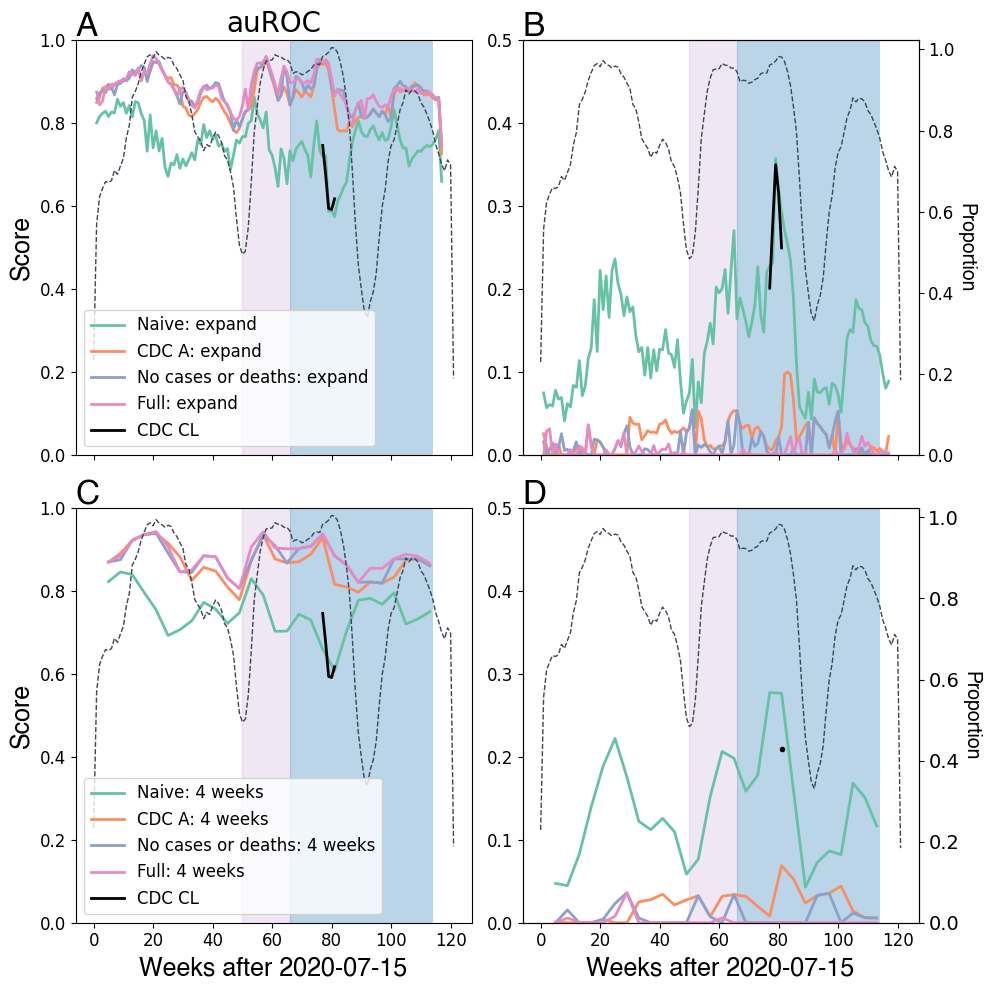

In [268]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10), sharex = 'all')
axs = axs.ravel()
weeks_to_predict_full = range(1, 118)


weeks_to_predict_every_four_weeks_graph = range(5,  max(weeks_to_predict_full),4)

axs[0].plot(weeks_to_predict_full,  ROC_by_week_naive_exact, label='Naive: expand', linewidth = 2, color = palette[0])
axs[0].plot(weeks_to_predict_full,  ROC_by_week_CDC_A_exact, label='CDC A: expand', linewidth = 2, color = palette[1])
axs[0].plot(weeks_to_predict_full,  ROC_by_week_full_exact_removed, label='No cases or deaths: expand', linewidth = 2, color = palette[2])
axs[0].plot(weeks_to_predict_full,  ROC_by_week_full_exact, label='Full: expand', linewidth = 2, color = palette[3])
axs[0].plot(range(77, 82), ROC_by_week_CL_mod[indices_for_CL[0]:indices_for_CL[-1] + 1], label='CDC CL', linewidth=2, color='black')

axs[2].plot(weeks_to_predict_every_four_weeks_graph,  ROC_by_week_naive_4, label='Naive: 4 weeks', linewidth = 2, color = palette[0])
axs[2].plot(weeks_to_predict_every_four_weeks_graph,  ROC_by_week_CDC_A_4, label='CDC A: 4 weeks', linewidth = 2, color = palette[1])
axs[2].plot(weeks_to_predict_every_four_weeks_graph,  ROC_by_week_no_c_d_4, label='No cases or deaths: 4 weeks', linewidth = 2, color = palette[2])
axs[2].plot(weeks_to_predict_every_four_weeks_graph,  ROC_by_week_full_4, label='Full: 4 weeks', linewidth = 2, color = palette[3])
axs[2].plot(range(77, 82), ROC_by_week_CL_mod[indices_for_CL[0]:indices_for_CL[-1] + 1], label='CDC CL', linewidth=2, color='black')


axs[0].plot(range(0, len(exceed_threshold)), exceed_threshold, label='', linewidth = 1, color = '#3C4553', linestyle = '--')
axs[2].plot(range(0, len(exceed_threshold)), exceed_threshold, label='', linewidth = 1, color = '#3C4553', linestyle = '--')


axs[0].set_title("auROC",fontsize=20)

# Plot MR 
second_axs = axs[1].twinx()
for i, model in enumerate(models_expand):
    colour = palette[i]
    if model == 'CDC CL':
        colour = 'black'
        axs[1].plot(range(77, 82), maximum_regret_by_model_ROC_expand[model][indices_for_CL_MR[0]:indices_for_CL_MR[-1]+1], label=model, linestyle = '-', color = colour, linewidth=2)
    else:
        axs[1].plot(weeks_to_predict_full, maximum_regret_by_model_ROC_expand[model], label=model, linestyle = '-', color = colour, linewidth=2)
second_axs.plot(range(0, len(exceed_threshold)), exceed_threshold, label='', linewidth = 1, color = '#3C4553', linestyle = '--')
second_axs.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])

second_axs.tick_params(axis='both', which='major', labelsize=12)
second_axs.set_ylabel('Proportion',**hfont, rotation=-90, fontsize = 14,  labelpad=15)
axs[1].set_ylim(0,0.5)
axs[3].set_ylim(0,0.5)


second_axs = axs[3].twinx()
for i, model in enumerate(models_4):
    colour = palette[i]
    if model == 'CDC CL':
        colour = 'black'
        axs[3].plot(weeks_to_predict_every_four_weeks_graph[indices_for_CL_MR_4[0]], maximum_regret_by_model_ROC_4[model][indices_for_CL_MR_4[0]], label=model, marker = '.', color = colour, linewidth=2)
    else:
        axs[3].plot(weeks_to_predict_every_four_weeks_graph, maximum_regret_by_model_ROC_4[model], label=model, linestyle = '-', color = colour, linewidth=2)
second_axs.plot(range(0, len(exceed_threshold)), exceed_threshold, label='', linewidth = 1, color = '#3C4553', linestyle = '--')
second_axs.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
second_axs.set_ylabel('Proportion',**hfont, rotation=-90, fontsize = 14,  labelpad=15)

second_axs.tick_params(axis='y', labelsize=14)


for i in range( len(axs)):
    print(i)
    axs[i].tick_params(axis='both', which='major', labelsize=12)
    polygon_delta = Polygon([(first_week_delta, 0), (first_week_delta, 100000), (last_week_delta, 100000), (last_week_delta, 0)],
                      alpha=0.3, color = '#cdb4db')
    axs[i].add_patch(polygon_delta)
    polygon_omricon = Polygon([(first_week_omricon, 0), (first_week_omricon, 100000), (last_week_omricon, 100000), (last_week_omricon, 0)],
                        alpha=0.3)
    axs[i].add_patch(polygon_omricon)
axs[0].set_ylabel('Score',**hfont,  fontsize = 18)
axs[2].set_ylabel('Score',**hfont,  fontsize = 18)

axs[0].set_ylim(0,1)
axs[2].set_ylim(0,1)
axs[1].set_ylim(0,0.5)
axs[3].set_ylim(0,0.5)

axs[2].set_xlabel('Weeks after 2020-07-15',**hfont,  fontsize = 18 )
axs[3].set_xlabel('Weeks after 2020-07-15',**hfont,  fontsize = 18 )

add_labels_to_subplots(axs, hfont, 1.01, 24)
axs[0].legend(ncol = 1, loc='lower left', fontsize='12')
axs[2].legend(ncol = 1, loc='lower left', fontsize='12')

plt.tight_layout()

plt.savefig(f'/Users/rem76/Documents/COVID_projections/Exact_analysis/Graphs/Performance_MR_naive_and_full_removed_expanding_train_models_exact_{size_of_test_dataset}_week_four_week_delivery_by_metric.png', dpi = 300, bbox_inches='tight' )